A couple utility functions to plot grayscale 28x28 image:

In [1]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 17.  오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

**오토인코더**는 어떤 지도 없이도 잠재 표현, 코딩(부호화)라 불리는 입력데이터의 밀집 표현을 학습할 수 있는 신경망 이다.   
일반적으로 입력 보다 훨씬 낮은 차원을 가지므로 **오토인코더**가 차원축소, 시각화에 특히 유용하게 사용된다.  
마지막으로 일부 오토인코더는 훈련 데이터와 매우 비슷한 새로운 데이터를 생성하는데 이를 **생성 모델**이라고 한다. 하지만 생성된 이미지가 흐릿하고 실제 이미지 같진 않다.  

*ex) 9 차원(sparse)에서 2 차원(dense)으로 표현하는것*

![autoencoder](./images/autoencoders/autoencoder.png)

![autoencoder1](./images/autoencoders/autoencoder1.png)

입력을 내부 표현으로 바꾸는 **인코더**와 내부 표현을 출력으로 바꾸는 **디코더**이다.  

출력층의 뉴런 수가 입력 개수와 동일하다는 것을 제외하면, 일반적으로 오토인코더는 MLP와 구조가 동일하다. 

**생성적 적대 신경망(GAN)** 으로 생성한 얼굴은 이를 가짜 이미지라고 믿기 힘들 정도이다. **GAN** 은 이미지 해상도 높이기, 이미지를 컬러로 바꾸기, 데이터 증식, 데이터 생성등 여러 다른 종류의 데이터를 생성, 다른 모델의 취약점을 식별하고 계산하기에 널리 사용된다.  


**autoencoder와 GAN** 모두 비지도 학습이며 둘 다 밀집 표현을 학습하고 생성 모델로 사용할 수 있지만 작동방식은 크게 다르다.

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
import numpy as np
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [7]:
import tensorflow as tf
import tensorflow.keras as keras

np.random.seed(42)
tf.random.set_seed(42)

#인코더 다음에 디코더가 뒤따르는 sequential 모델

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])]) # 3차원을 2차원으로 
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])]) # 2차원을 3차원으로, 결국엔 입력과 출력개수가 동일
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [8]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 935us/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 718us/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 861us/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 867us/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 757us/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 779us/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 868us/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 744us/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 720us/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 742us/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 702us/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 738us/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] 

In [9]:
codings = encoder.predict(X_train)

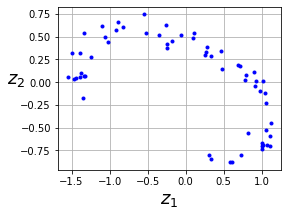

In [15]:
# 오토인코더의 은닉층 출력 
import matplotlib.pylab as plt 
from matplotlib.pyplot import savefig as save_fig

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [16]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

앞서 살펴봤던 다른 신경망과 마찬가지로 오토인코더도 은닉층을 여러 개 가질 수 있다. 이런 경우를 **적층 오토인코더**라고 한다.   
그러나 너무 강력해지지 않도록 주의해야 한다. 훈련 데이터를 완벽하게 재구성하겠지만 이 과정에서 유용한 데이터 표현을 학습하지 못할 것이다.

![autoenco](./images/autoencoders/autoencoder3.png)

적층 오토인코더 구조는 전형적으로 가운데 은닉층을 기준으로 대칭이다. 

## 케라스를 사용하여 적층 오토인코더 구현하기

인코더는 28 * 28 픽셀의 흑백이미지를 받아서 784 크기의 벡터로 표현하기 위해 펼친 후 점점 줄어드는 dense층 두 개에 통과 시키고 디코더는 반대로  
적층 오터인코더를 컴파일할때 MSE 대신 binary-crossentropy를 사용한다. 

In [17]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9007
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2987 - val_rounded_accuracy: 0.9195
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

## 재구성 시각화

**오토인코더**가 적절히 훈련되었는지 확인하려면 입력과 출력을 비교하는것이다.   
다음 출력 결과는 재구성된 이미지를 식별할 수는 있지만 정보를 조금 많이 잃었다.   
모델을 더 오래 훈련하거나 인코더와 디코더의 층을 늘리거나 코딩의 크기를 늘려야 할 지도 모른다.

In [19]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

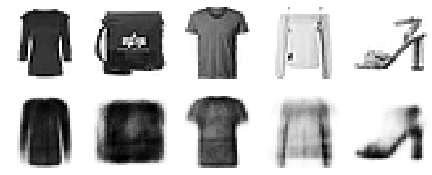

In [20]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

다른 차원 축소 알고리즘 만큼 좋은 결과를 주지는 못하지만 샘플과 특성이 많은 대용량 데이터셋을 다룰 수 있다는 장점이 있다.  
따라서 **오토인코더**를 사용해 적절한 수준으로 차원을 축소한 후 다른 차원 축소 알고리즘을 사용해 시각화 해보는 것도 전략이다.

In [21]:
np.random.seed(42)

#t-SNE 알고리즘을 구현

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

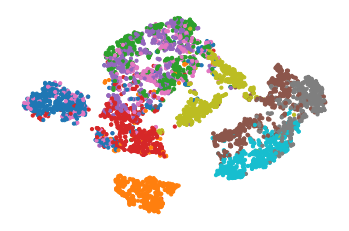

In [22]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

### t-SNE 알고리즘이 식별한 클러스터가 클래스와 잘 매칭된다. 

*차원축소(dimesionality reduction)와 시각화(visualization) 방법론으로 널리 쓰이는 t-SNE(Stochastic Neighbor Embedding) 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 인기있는 알고리즘이기도 하다.*

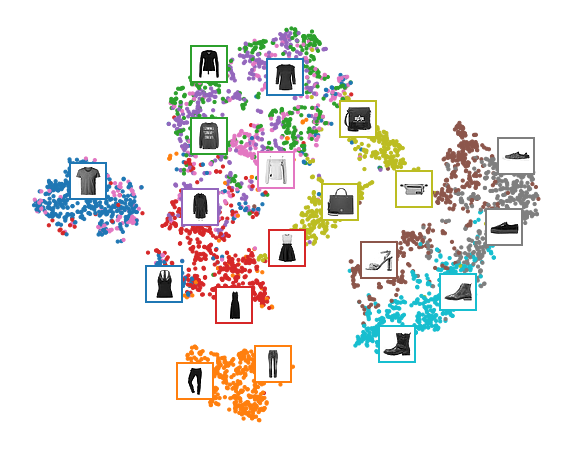

In [24]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

**오토인코더**가 완벽하게 대칭일 땐 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적인 방법이다. 이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄여서 훈련속도를 높이고 과대적합의 위험을 줄여준다.

In [25]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True) # 행렬 곱
        return self.activation(z + self.biases)

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu") 

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2  # 새로운 적층 인코더 
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"), 
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, # 에포크를 절반으로 줄였음에도 비슷한 결과가 나옴
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3080 - val_rounded_accuracy: 0.9081
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2952 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [=================

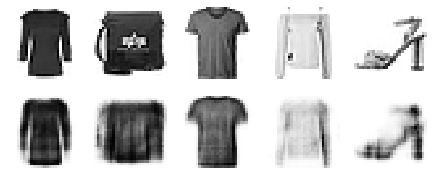

In [27]:
show_reconstructions(tied_ae)
plt.show()

## 한 번에 오토인코더 한 개씩 훈련하기

**greedy layerwise training** 

매 순간 순간마다 최적의 선택을 하는 알고리즘, 미래를 생각하지 않고 그 순간에서만 최적인 선택을 하기 때문에 모든 경우에서 통하진 않음



In [28]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [30]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

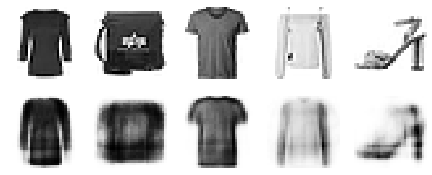

In [31]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [32]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [=================

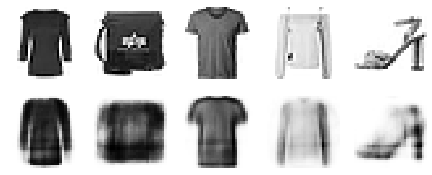

In [33]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

이미지에 대한 오토인코더를 만들려면 **합성곱 오토인코더**를 만들어야 한다.

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"), # 주로 오토인코더에서는 tanh과 sigmoid를 사용,픽셀값이 1을 넘지 않게 하려는듯
    
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2850 - val_rounded_accuracy: 0.9284
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2730 - val_rounded_accuracy: 0.9453
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2685 - val_rounded_accuracy: 0.9493
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2670 - val_rounded_accuracy: 0.9511


In [36]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)        

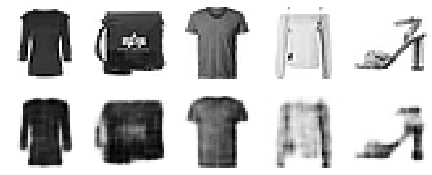

In [37]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

시계열이나 텍스트와 같은 시퀀스에 대한 오토인코더를 만들려면 순환 신경망이 밀집(dense) 네트워크보다 더 나을 수 있다. 

각 타임스텝에서 28픽셀의 행 하나를 처리한다. 

![timestep](./images/autoencoders/timestep.png)

In [38]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]), # 타임 스텝마다 입력 벡터를 주입하기 위해 
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [39]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3740 - val_rounded_accuracy: 0.8683
Epoch 3/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3603 - val_rounded_accuracy: 0.8768
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3525 - val_rounded_accuracy: 0.8771
Epoch 5/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3334 - rounded_accuracy: 0.8922 - val_loss: 0.3305 - val_rounded_accuracy: 0.8964
Epoch 7/10
1719/1719 [======

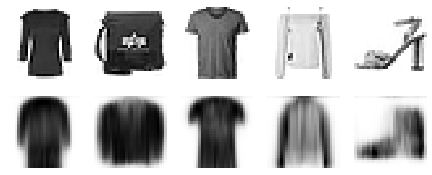

In [40]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

지금까지는 **undercomplete Autoencoder**를 살펴봤는데 지금부터 **overcomplete Autoencoder**를 살펴보자

![under](./images/autoencoders/under.png)

## 잡음 제거 오토인코더

입력에 잡음을 추가하고, 잡음이 없는 원본 입력을 복원하도록 훈련하는 것 잡음은 입력에 추가된 순수한 가우시안 잡음이거나 드롭아웃 처럼 무작위로 입력을 꺼서 발생시킬 수도 있다.


*가우시안 잡음* 

*튀지 않고 랜덤한 일반적인 분포 (정규분포) 따르는 noise*

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), # 가우시안 노이즈
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3174 - val_rounded_accuracy: 0.9052
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9121
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

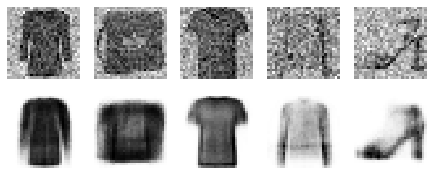

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # 드롭아웃
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [=================

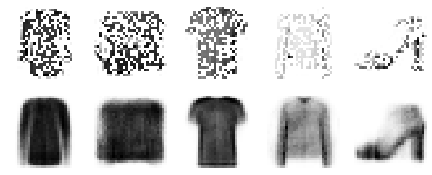

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

좋은 특성을 추출하도록 만드는 다른 제약의 방식은 **희소**(sparse) 입니다. 이는 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화 되는 뉴런 수를 감소시키도록 만든다. 예를 들어 코딩 층에서 평균적으로 5% 뉴런만 활성화 되도록 할 수 있다. 이렇게 하면 각 층의 유용한 특성을 표현하게 된다.  

간단한 방법은 코딩을 0과 1사이 값으로 제한하기 위해 시그모이드를 사용하고 큰 코딩 층을 사용하는 것 코딩 층의 활성화 값에 $l_1$ 규제를 추가한다.

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

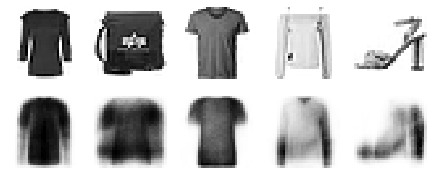

In [36]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [37]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [38]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

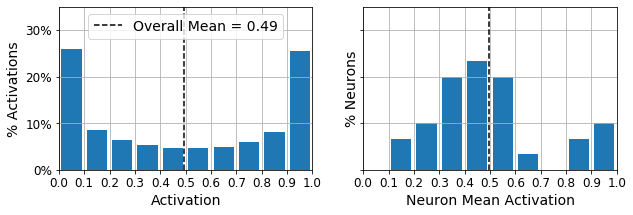

In [39]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

$l_1$ 규제는 훈련 손실에 입력의 절댓값의 합을 더 하면서 입력 이미지에서 불필요한 것을 제거하고 가장 중요한 코딩을 보전하도록 만든다. 
각 뉴런에 대한 평균 활성화 정도를 알면 비용 함수에 **희소 손실**을 추가하여 너무 활성화 되거나 충분히 활성화 되지 않은 뉴런에 벌칙을 가할 수 있다. 이 때 MSE 보다 훨씬 강력한 **쿨백-라이블러 발산**을 사용한다.

- 정보량: $I(x) = -logP(x) $  


- 엔트로피 : 정보량의 기댓값 즉, $H(p) = E(-logP(x))= \Sigma -P(x)logP(x) $ (이산형일때)  


- 크로스 엔트로피 : 예측하고자 하는 분포 Q의 기댓값 $H(p,q) = E(-logQ(x)) = \Sigma -P(x)logQ(x) $  p,q가 모두 들어가 크로스를 붙였다함


- 쿨백-라이블러 발산 : *크로스 엔트로피 - 엔트로피*

그러므로 최대한 분포 P와 유사한 분포 Q를 찾는 과정으로 작을수록 두 분포가 유사하다는 의미

여기서는 각 뉴런이 활성화되었을때와 활성화 되지 않았을때 두 가지 경우라 더 간단하게 표현 가능한데 $p(목표 희소 정도)=0.1 , q(실제 희소 정도)=0.3$ 이라면 활성화 된 경우 $(p = 0.1, q = 0.3)$와 아닌 경우 $(p = 1-0.1 =0.9 , q = 1-0.3 =0.7)$에 대해 다음과 같이 계산한다.

$$H(p,q) = -(0.1\log0.3 + 0.9\log0.7)$$
$$H(p) = -(0.1\log0.1 + 0.9\log0.9)$$


$$D_KL(p||q) = 0.1\log\frac{0.1}{0.3} + 0.9\log\frac{0.9}{0.7}$$

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),   
    keras.layers.Dense(300, activation="sigmoid"),# 0에 가까운 코딩을 만들도록 유도
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
    
    
    
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [================

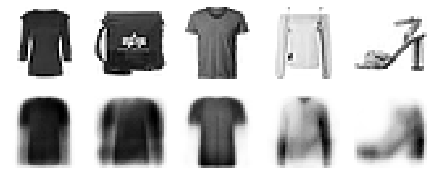

In [46]:
show_reconstructions(sparse_l1_ae)

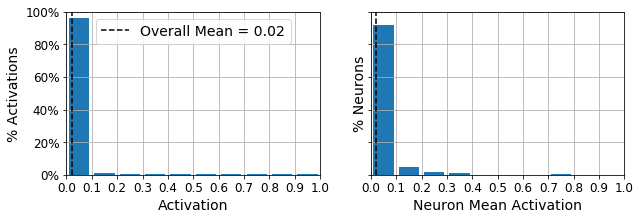

In [42]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show() # 0에 가깝게 나온것을 확인

Saving figure sparsity_loss_plot


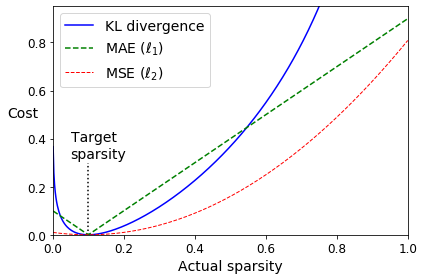

In [43]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [44]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1): 
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1) # 목표 희소 정도 0.1
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

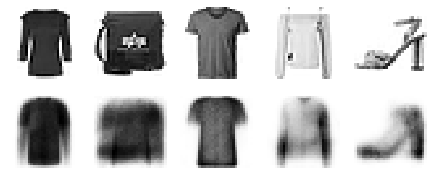

In [46]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


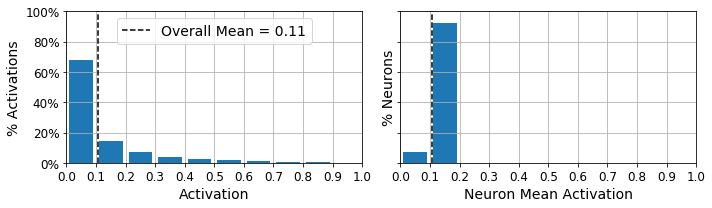

In [47]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show() # 전체활성화의 약 70%가 0.1 보다 작다. 전체 뉴런의 평균 활성화가 0.11이다.

# Variational Autoencoder

변이형 오토인코더는 다음과 같은 점에서 지금까지 다룬 오토인코더와 매우 다르다. 

- 확률적 오토인코더이다. 즉, 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정된다.

- 생성인코더 라는 점이다. 마치 훈련세트에서 샘플링 된 것 같은 새로운 샘플을 생성할 수 있다.

인코더는 **평균 코딩** 평균 $\mu$ 와 표준편차 $\sigma$ 를 만든다. 실제 코딩은 가우시안 분포에서 랜덤하게 샘플링되고 그 후 디코더가 샘플링 된 코딩을 보통처럼 디코딩 한다.

![vae](./images/autoencoders/vae.jpg)

그림에서와 같이 **변이형 오토인코더**는 입력이 매우 복잡한 분포를 가지더라도 간단한 가우시안 분포에서 샘플링 된 것처럼 보이는 코딩을 만드는 경향이 있다. 훈련하는 동안 비용함수가 코딩을 가우시안 샘플들의 군집처럼 보이도록 잠재공간 안으로 이동시킨다. 그러므로 **변이형 오토인코더**는 훈련이 끝난 뒤 가우시안 분포에서 랜덤한 코딩을 샘플링해 디코딩하면 된다.


비용함수는 두 부분으로 구성된다. 첫째는 오토인코더가 입력을 재생산하게 만드는 일반적인 재구성 손실, 둘째는 단순한 가우시안 분포에서 샘플된 것 같은 코딩을 가지도록 오토인코더를 강제하는 **잠재 손실**이다. 여기에는 목표 분포와 실제 코딩 분포 사이의 **KLD**를 사용한다. 


![vae1](./images/autoencoders/vae1.jpg)

$$ q(x) \thicksim N(\mu_1 ,\sigma_1) ,  p(x) \thicksim N(0,1)$$ 

### MNIST 데이터셋에서 변이형 오토인코더 만들기

In [47]:
class Sampling(keras.layers.Layer): # sampling 층은 mean과 log_var를 받음
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean #K.random를 이용하여 평균0, 분산1인 표준정규분포에서 랜덤한 벡터 샘플링

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var]) #실제 사용하는 출력
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs) # 인코더의 처음 두 개 출력을 무시하고 코딩만 주입
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum( # 잠재손실 계산
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.) # binary_crossentropy가 픽셀 당 평균을 더 하는것이 아닌 전체 픽셀에 대한 평균을 구하기 때문에 스케일을 맞춰줌
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy]) #재구성 손실
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3892 - rounded_accuracy: 0.8612 - val_loss: 0.3531 - val_rounded_accuracy: 0.8941
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3424 - rounded_accuracy: 0.8981 - val_loss: 0.3365 - val_rounded_accuracy: 0.9053
Epoch 3/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3327 - rounded_accuracy: 0.9053 - val_loss: 0.3330 - val_rounded_accuracy: 0.9069
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3277 - rounded_accuracy: 0.9093 - val_loss: 0.3280 - val_rounded_accuracy: 0.9119
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3246 - rounded_accuracy: 0.9119 - val_loss: 0.3276 - val_rounded_accuracy: 0.9127
Epoch 6/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3224 - rounded_accuracy: 0.9137 - val_loss: 0.3238 - val_rounded_accuracy: 0.9128
Epoch 7/25
430/430 [==============================

![vae2](./images/autoencoders/vae2.jpg)

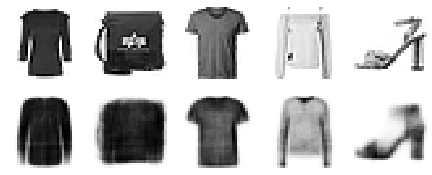

In [50]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [50]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

약간 흐릿하지만 겨우 몇 분간 훈련시킨것이고 세부튜닝을 하고 나면 훨씬 좋은 이미지가 만들어질 것 이다.

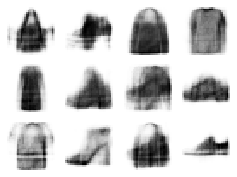

In [51]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

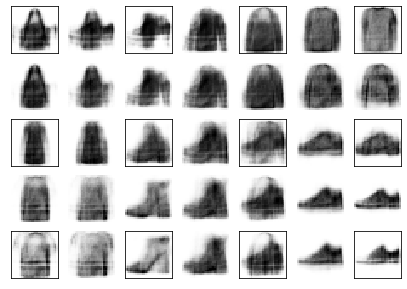

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("두개 겹쳐보이게 하는 시맨틱 보간", tight_layout=False)

지난 몇 년 간 변이형 오토인코더를 썼으나 요즘은 **GAN**이 훨씬 실제 같이 또렷한 이미지를 만들 수 있어서 인기가 많다.

# Generative Adversarial Networks

**생성자**  

랜덤한 분포를 입력으로 받고 이미지와 같은 데이터를 출력한다. 랜덤한 입력은 생성할 이미지의 잠재표현으로 생각할 수 있다. 생성자는 변이형 오토인코더의 디코더와 같은 기능을 제공한다. 하지만 훈련방식은 매우 다르다.  

**판별자**  

생성자에서 얻은 가짜 이미지나 훈련세트에서 추출한 진짜 이미지를 입력으로 받아 입력된 이미지가 가짜인지 진짜인지 구분한다.  


![gan](./images/autoencoders/gan.png)


훈련하는 동안 생성자와 판별자의 목표는 반대이다. 


- 첫 번째 단계에서 판별자를 훈련한다. 훈련 세트에서 실제 이미지를 배치 샘플링하고 생성자에서 생성한 동일한 수의 가짜 이미지를 합친다. 가짜 이미지의 레이블은 0으로 세팅하고 진짜 이미지는 1로 세팅한다.  


- 두 번째 단계에서 생성자를 훈련한다. 먼저 생성자를 이용해 다른 가짜 이미지배치를 만들고 다시 판별자를 사용해 이미지가 진짜인지 아닌지 판별한다. 생성자가 판별자가 진짜라고 잘못 믿을 이미지를 만들어야 한다. 이 단계 동안에는 판별자의 가중치를 동결하는 것이 중요하다.

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"), 
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [54]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # 두번째 단계에서 판별자를 훈련하면 안된다.
                                # trainable은 컴파일 할 때만 영향 미침
    
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [57]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
#dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [58]:
dataset

<ShuffleDataset shapes: (28, 28), types: tf.float32>

In [59]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [60]:
dataset

<PrefetchDataset shapes: (32, 28, 28), types: tf.float32>

In [57]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # 가우시안 잡음을 생성자에 주입하여 가짜 이미지 생성
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 가짜일 경우 0이고 진짜는 1
            discriminator.trainable = True                              # 판별자 훈련 TRUE
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # 가우시안 잡음 주입
            y2 = tf.constant([[1.]] * batch_size)                      # 판별자가 가짜 이미지를 진짜로 믿게 만들고 싶으므로 1로 지정
            discriminator.trainable = False                           # 판별자 훈련 FALSE
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


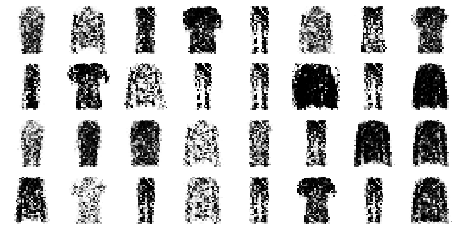

In [58]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


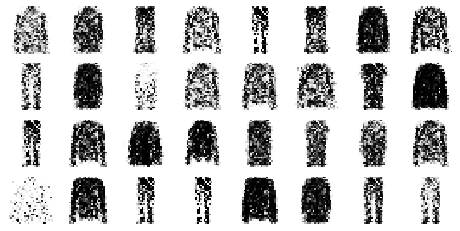

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


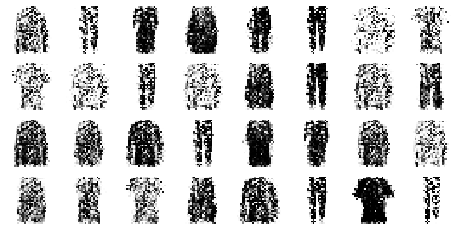

Epoch 2/50


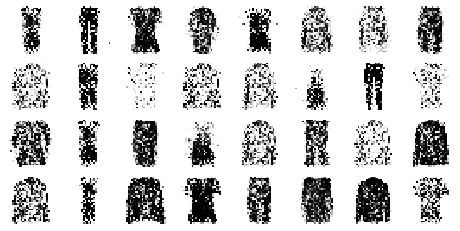

Epoch 3/50


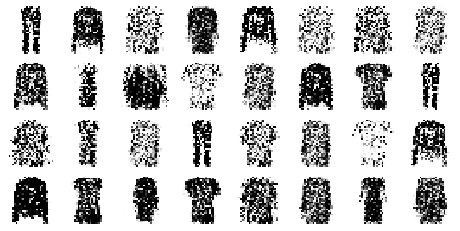

Epoch 4/50


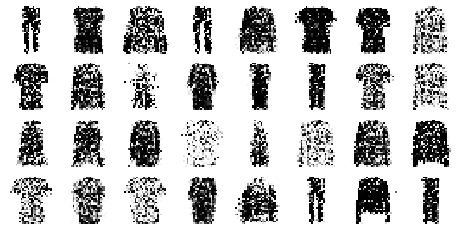

Epoch 5/50


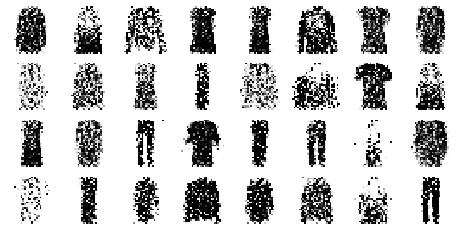

Epoch 6/50


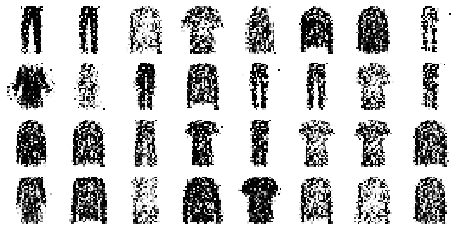

Epoch 7/50


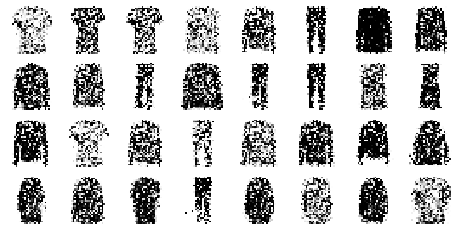

Epoch 8/50


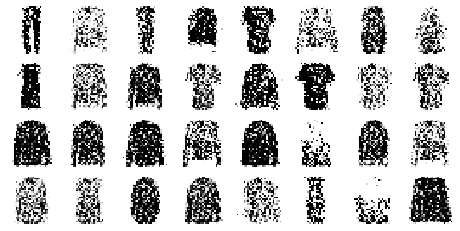

Epoch 9/50


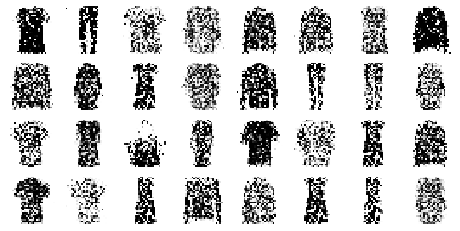

Epoch 10/50


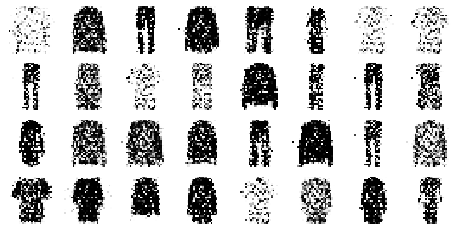

Epoch 11/50


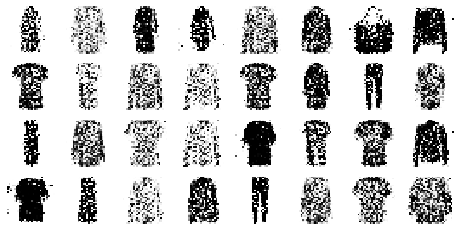

Epoch 12/50


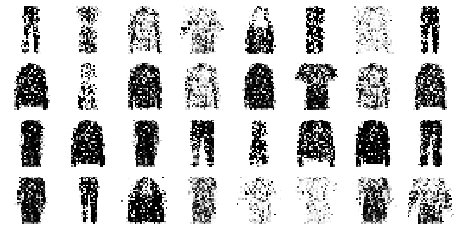

Epoch 13/50


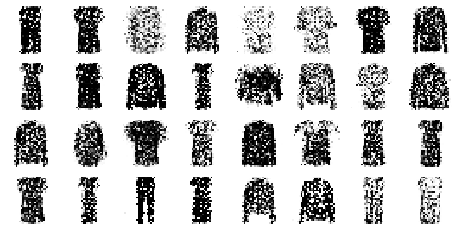

Epoch 14/50


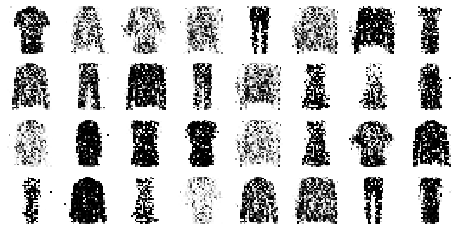

Epoch 15/50


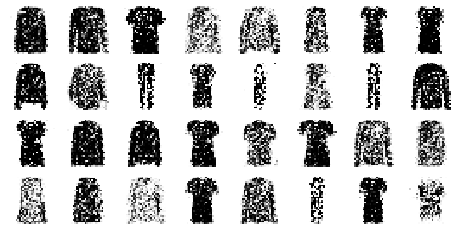

Epoch 16/50


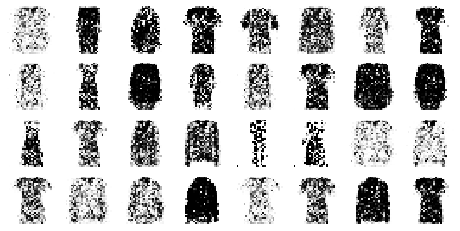

Epoch 17/50


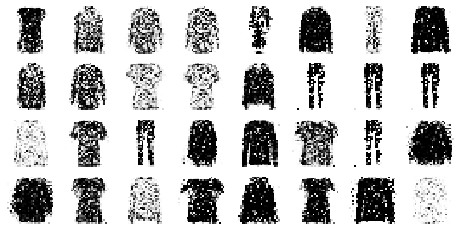

Epoch 18/50


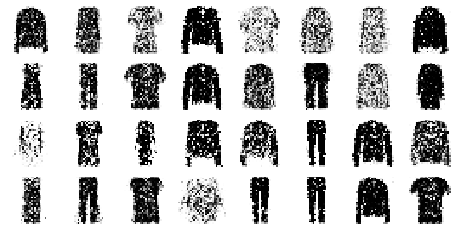

Epoch 19/50


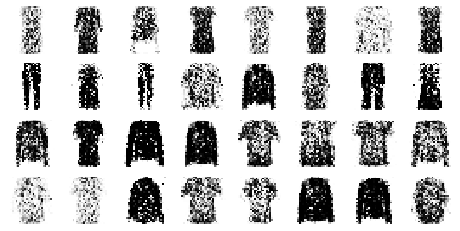

Epoch 20/50


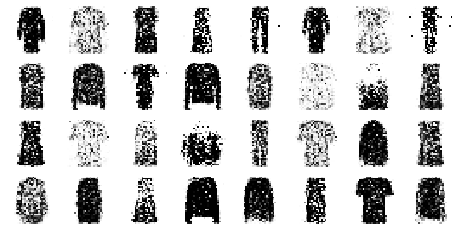

Epoch 21/50


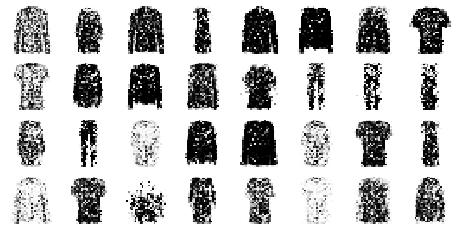

Epoch 22/50


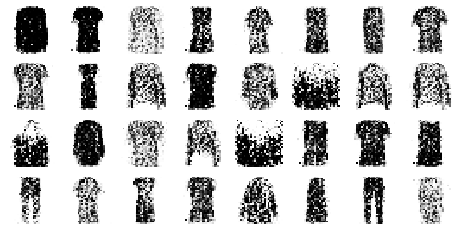

Epoch 23/50


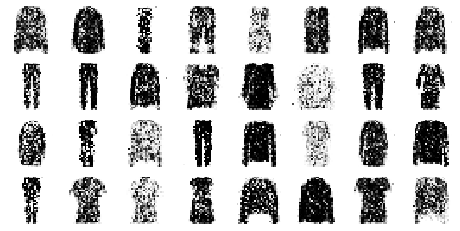

Epoch 24/50


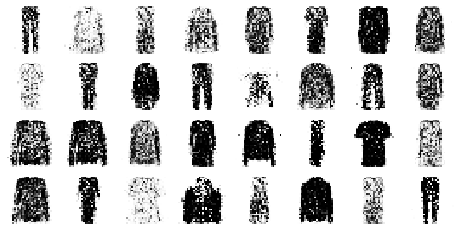

Epoch 25/50


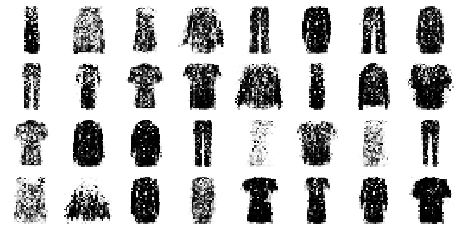

Epoch 26/50


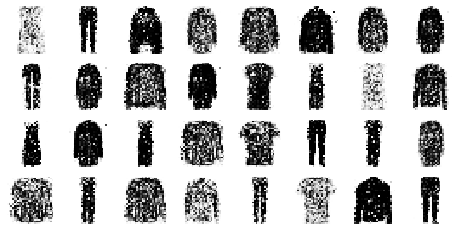

Epoch 27/50


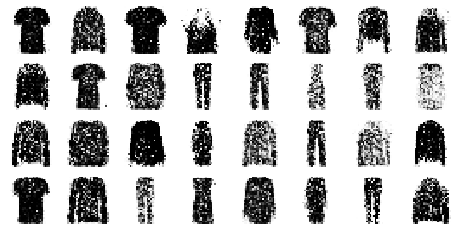

Epoch 28/50


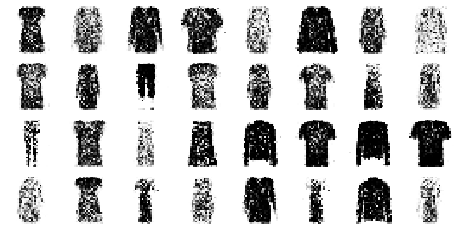

Epoch 29/50


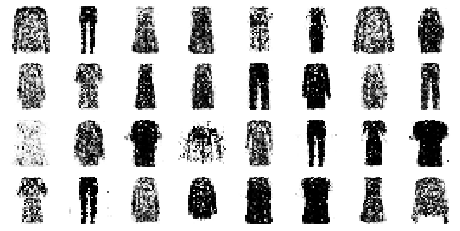

Epoch 30/50


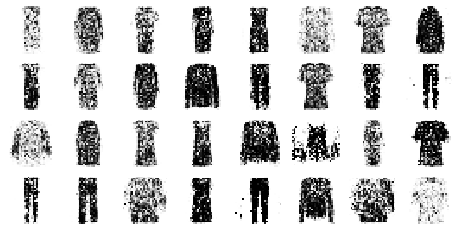

Epoch 31/50


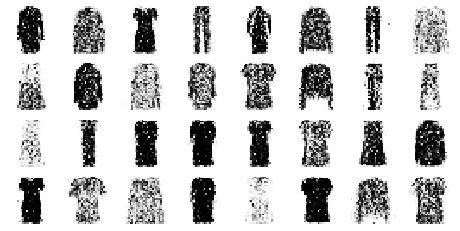

Epoch 32/50


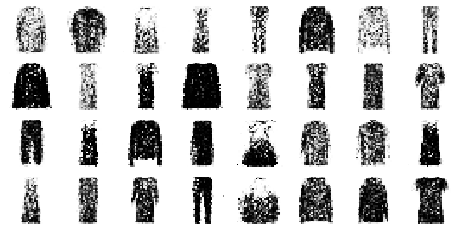

Epoch 33/50


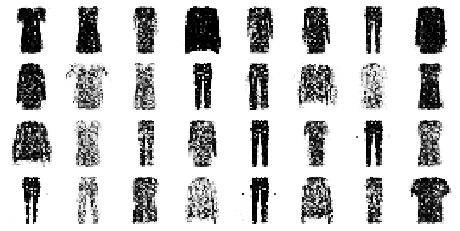

Epoch 34/50


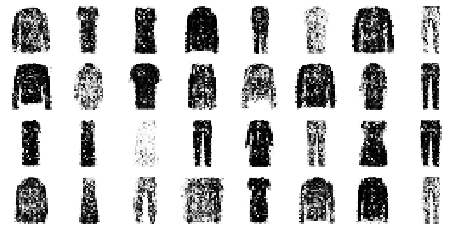

Epoch 35/50


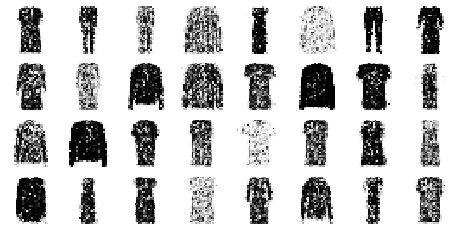

Epoch 36/50


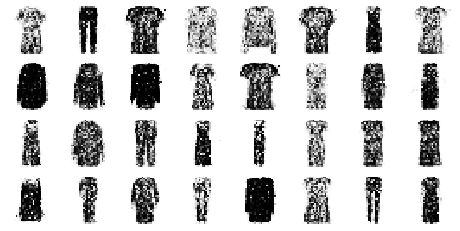

Epoch 37/50


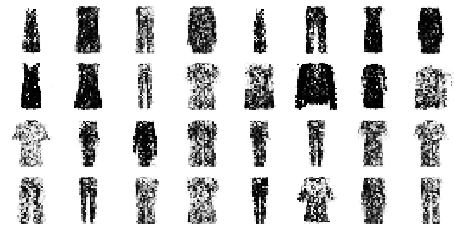

Epoch 38/50


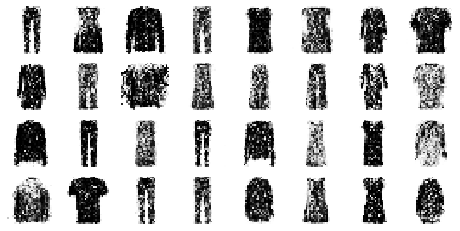

Epoch 39/50


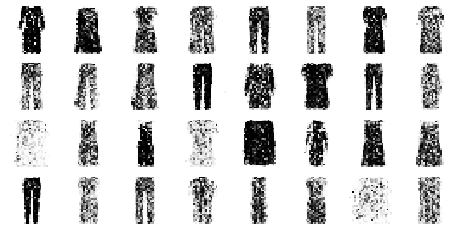

Epoch 40/50


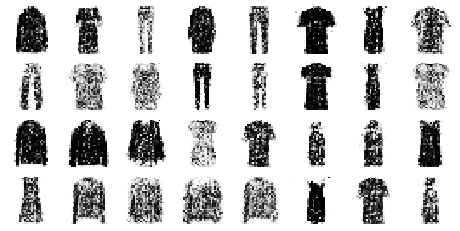

Epoch 41/50


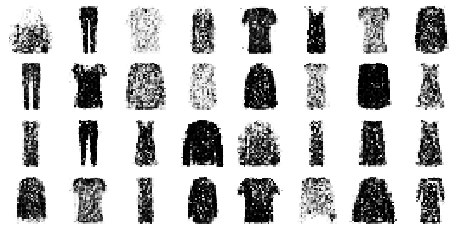

Epoch 42/50


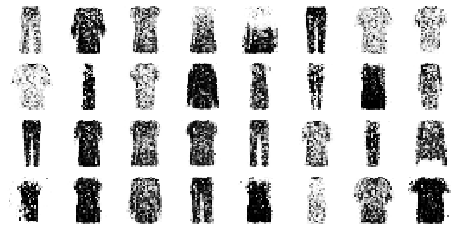

Epoch 43/50


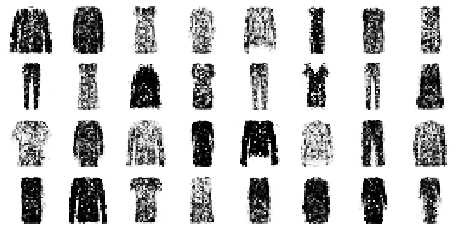

Epoch 44/50


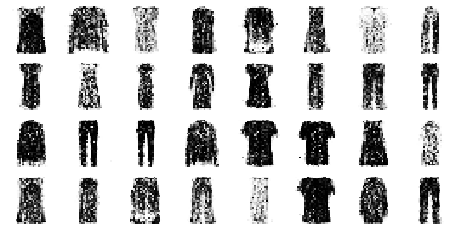

Epoch 45/50


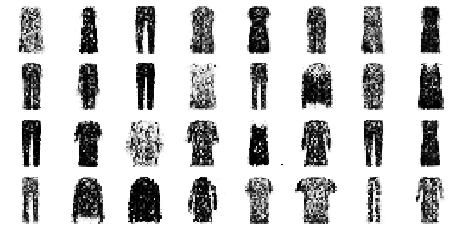

Epoch 46/50


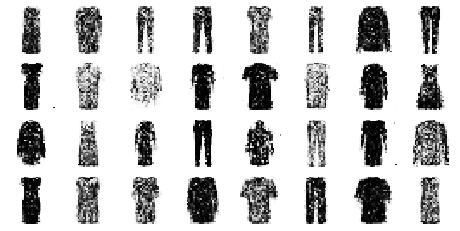

Epoch 47/50


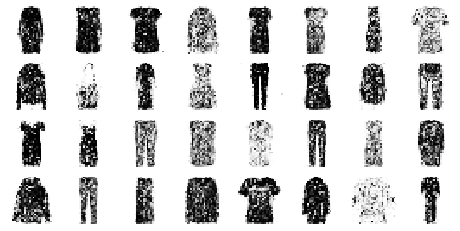

Epoch 48/50


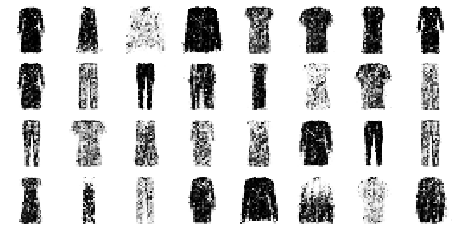

Epoch 49/50


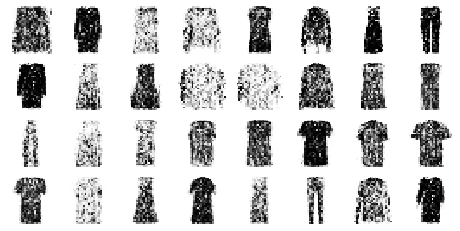

Epoch 50/50


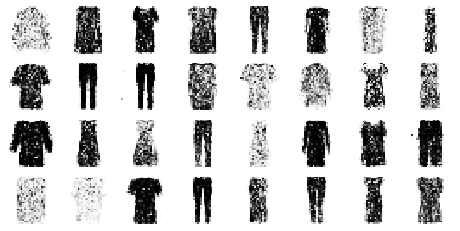

In [60]:
train_gan(gan, dataset, batch_size, codings_size)

## GAN 훈련의 어려움

생성자와 판별자가 지속적으로 서로에게 영향을 주기 때문에 파라미터 변동이 크고 불안정해질 수 있다. 특별한 이유 없이도 갑자기 발산할 수도 있다. 여러 요인이 복잡한 역학 관계에 영향을 주어 GAN은 하이퍼 파라미터에 매우 민감하고 튜닝하기 위해 많은 노력이 필요하다.  
아직까지 완벽하게 파악하지는 못했지만 많은 진전이 있었다. 그 중 뛰어난 최신 구조를 알아보자

# Deep Convolutional GAN

- 풀링 층을 스트라이드 합성곱으로 바꾸고 풀링 층은 전치 합성곱으로 바꾼다.  


- 생성자와 판별자에 배치 정규화를 사용한다. 생성자의 출력층과 판별자의 입력층은 제외한다.  


- 층을 깊게 쌓기 위해 완전 연결 은닉층을 제거한다.  


- tanh 함수를 사용해야 하는 출력층은 제외하고 생성자의 모든 층은 ReLU 활성화 함수를 사용한다.  


- 판별자의 모든 층은 LeakyReLU 활성화 함수를 사용한다.  


*LeakyReLU : ReLU의 장점을 가지고 있지만 그래디언트가 죽지 않음*

In [62]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100 # 생성자는 크기 100의 코딩을 받아

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]), # 6272차원으로 투영하고 이 결과를 7*7*128 크기의 텐서로 바꿈
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),                           # 배치정규화
    
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", 
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),            # 출력 범위 -1~1
]) 
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [63]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [64]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [65]:
X_train_dcgan

array([[[[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        ...,

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]],

        [[-1.        ],
         [-1.        ],
         [-1.        ],
         ...,
         [-1.        ],
         [-1.        ],
         [-1.        ]]],


       [[[-1.        ],


In [64]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


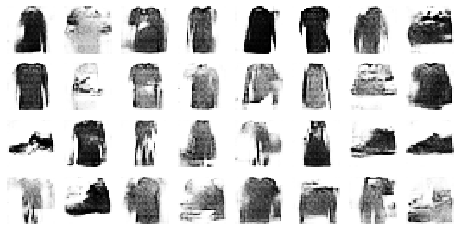

Epoch 2/50


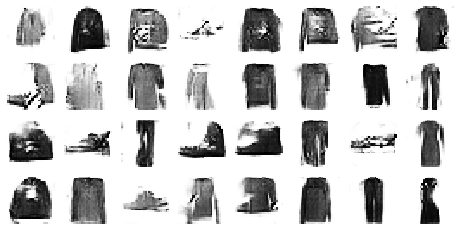

Epoch 3/50


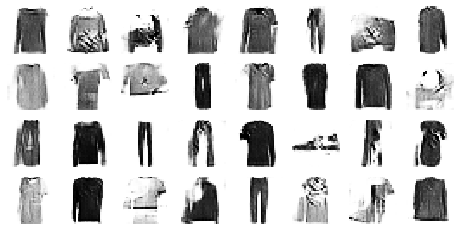

Epoch 4/50


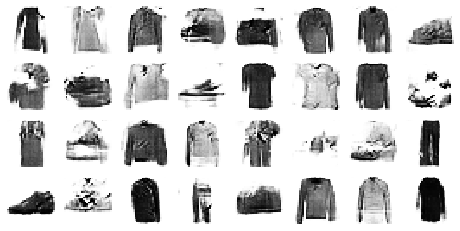

Epoch 5/50


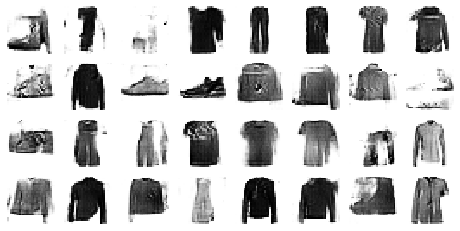

Epoch 6/50


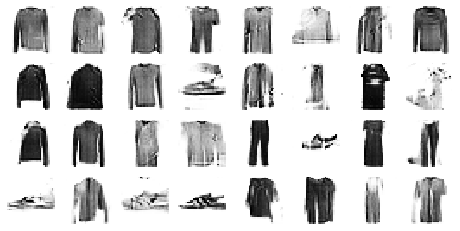

Epoch 7/50


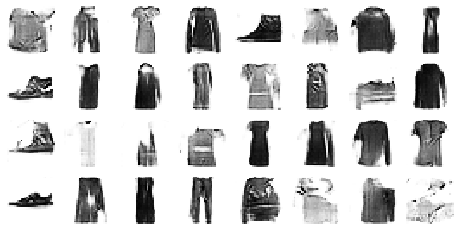

Epoch 8/50


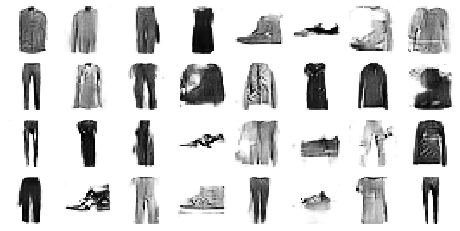

Epoch 9/50


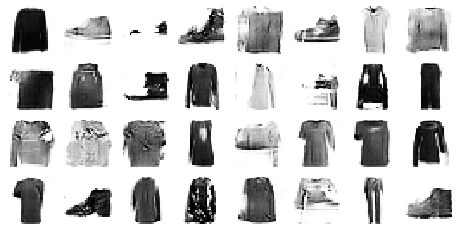

Epoch 10/50


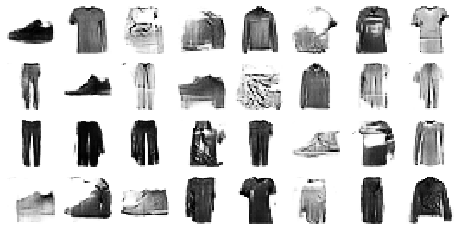

Epoch 11/50


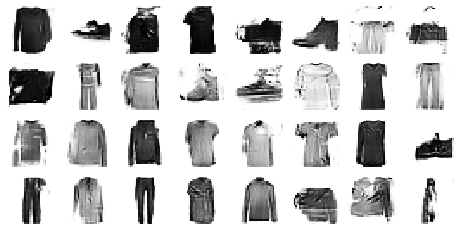

Epoch 12/50


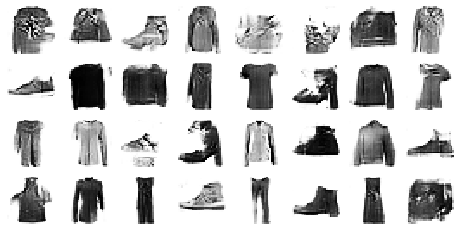

Epoch 13/50


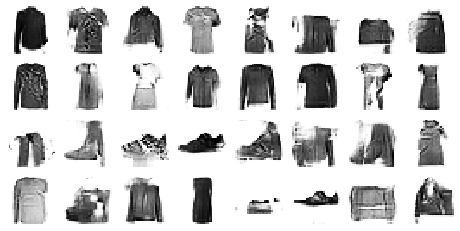

Epoch 14/50


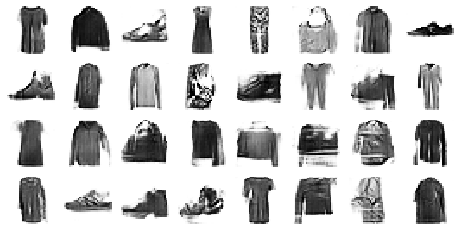

Epoch 15/50


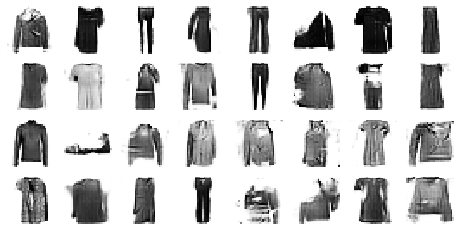

Epoch 16/50


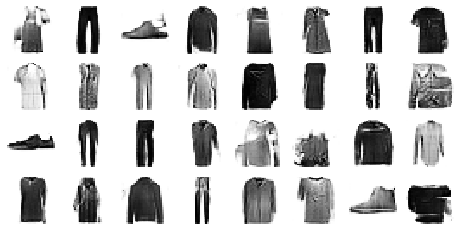

Epoch 17/50


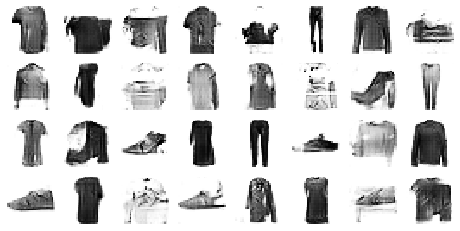

Epoch 18/50


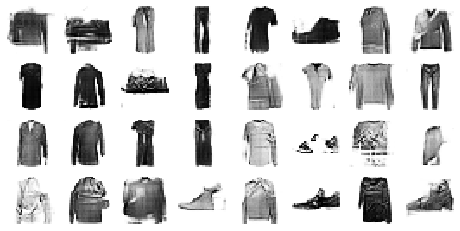

Epoch 19/50


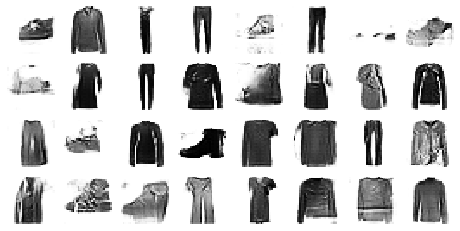

Epoch 20/50


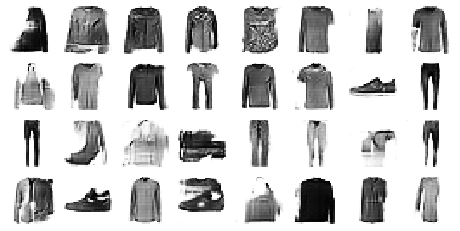

Epoch 21/50


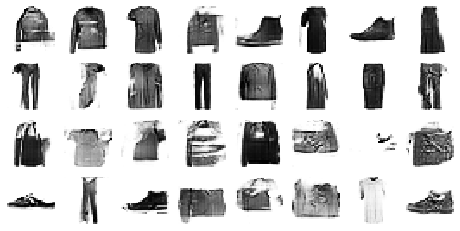

Epoch 22/50


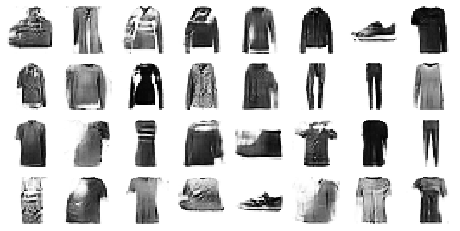

Epoch 23/50


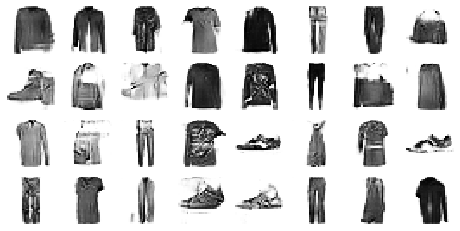

Epoch 24/50


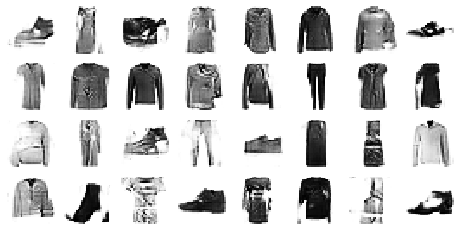

Epoch 25/50


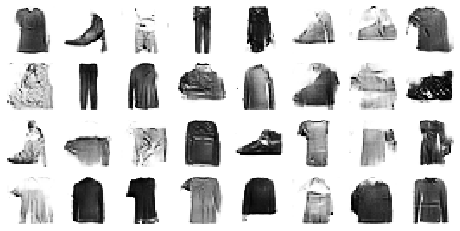

Epoch 26/50


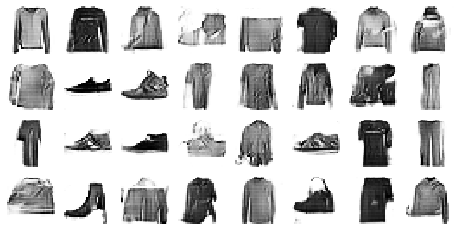

Epoch 27/50


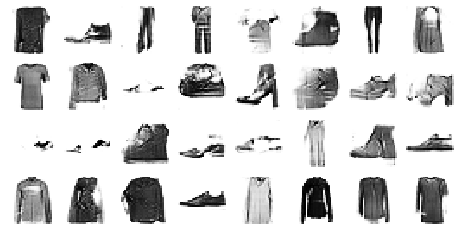

Epoch 28/50


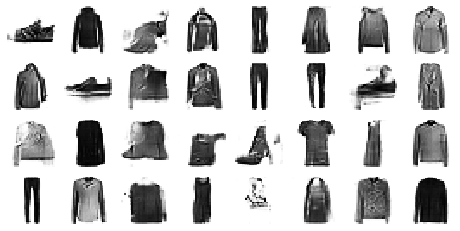

Epoch 29/50


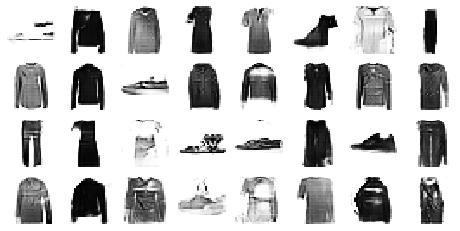

Epoch 30/50


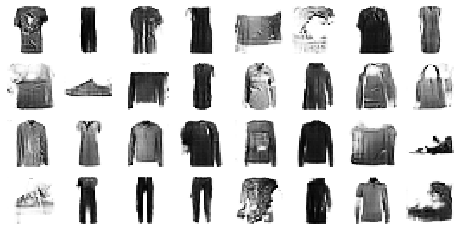

Epoch 31/50


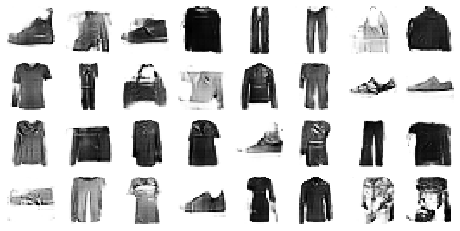

Epoch 32/50


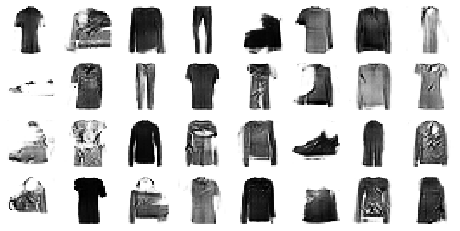

Epoch 33/50


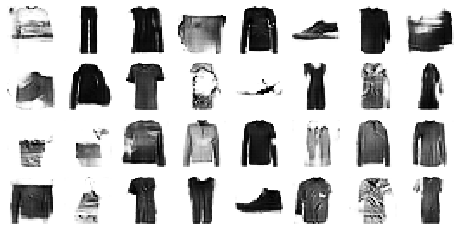

Epoch 34/50


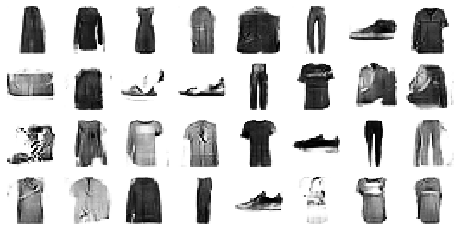

Epoch 35/50


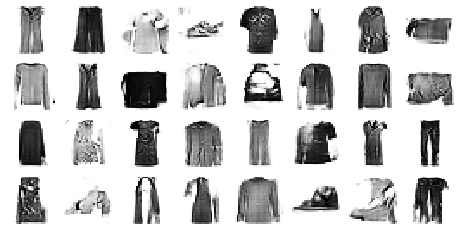

Epoch 36/50


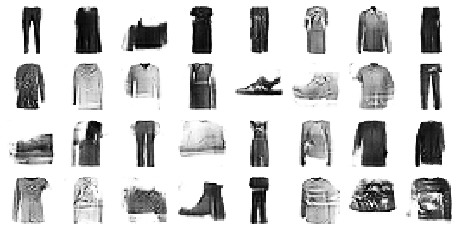

Epoch 37/50


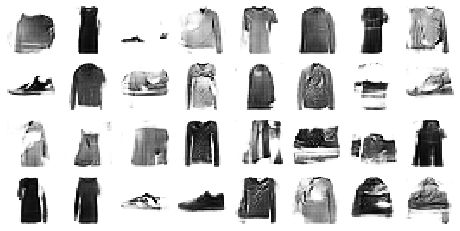

Epoch 38/50


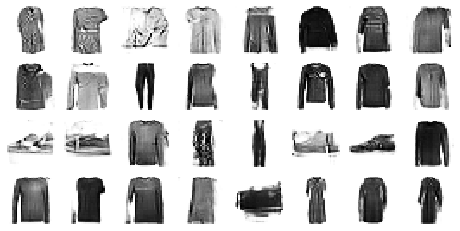

Epoch 39/50


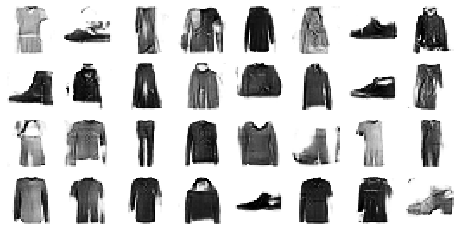

Epoch 40/50


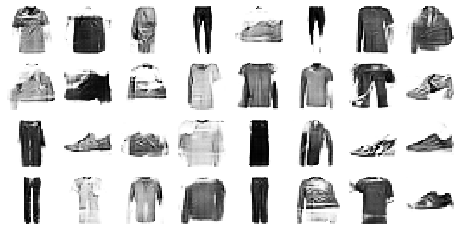

Epoch 41/50


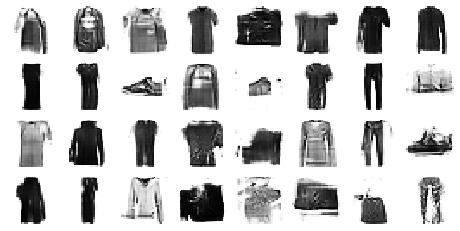

Epoch 42/50


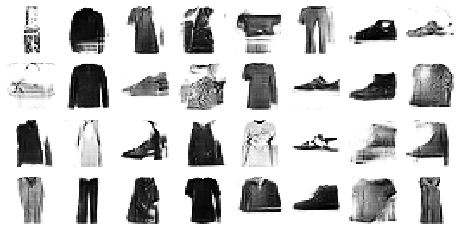

Epoch 43/50


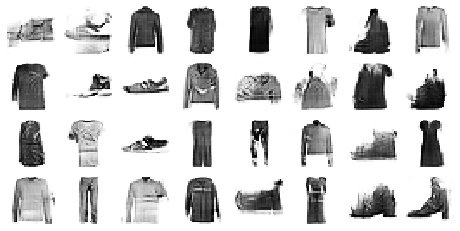

Epoch 44/50


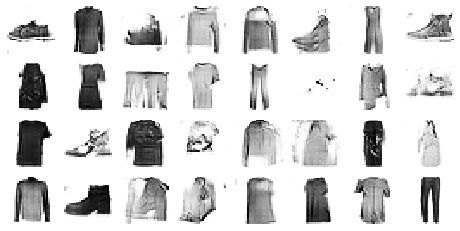

Epoch 45/50


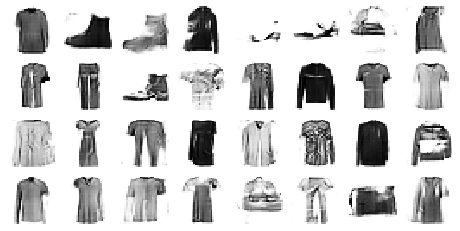

Epoch 46/50


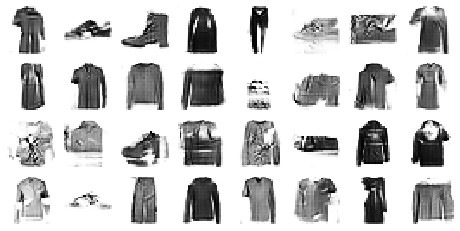

Epoch 47/50


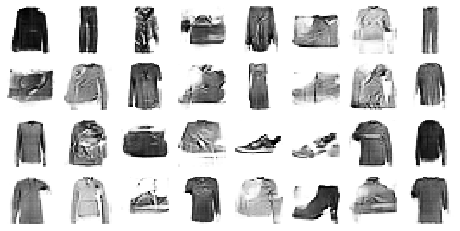

Epoch 48/50


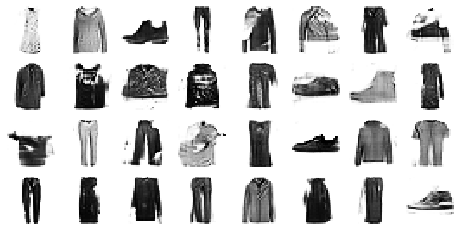

Epoch 49/50


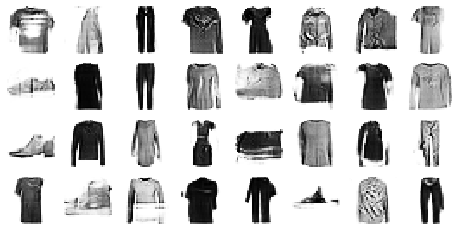

Epoch 50/50


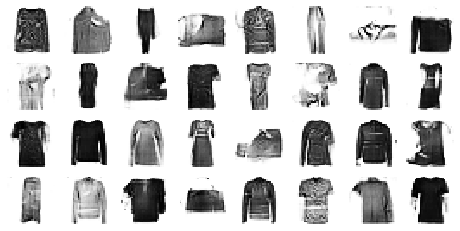

In [65]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


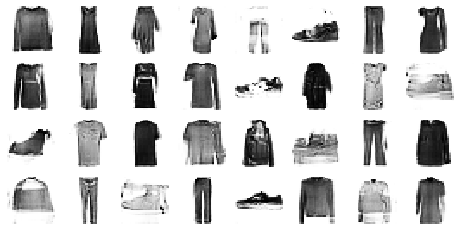

In [66]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

## ProGAN

![pro](./images/autoencoders/progan.gif)

- 초기에 작은 이미지를 생성하고 점진적으로 생성자와 판별자에 합성곱층을 추가해갈수록 큰 이미지를 만드는 방법  


- ProGAN은 고품질의 이미지를 생성하지만, 대부분의 모델과 같이 생성된 이미지의 구체적인 특징을 컨트롤하는 능력은 매우 제한적



## StyleGAN

![style](./images/autoencoders/style.png)

- ProGAN의 이미지 generator의 업그레이드된 버전을 제안  
 
 
- ProGAN + 각 층에 이미지의 Style을 캡쳐한다는 특징  


- style mixing 가능



# Exercise Solutions

## Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 0s 24ms/step - loss: 2.1818 - accuracy: 0.2720 - val_loss: 1.9767 - val_accuracy: 0.4202
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.7830 - accuracy: 0.5320 - val_loss: 1.6235 - val_accuracy: 0.5362
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4087 - accuracy: 0.5980 - val_loss: 1.2586 - val_accuracy: 0.6058
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0865 - accuracy: 0.6920 - val_loss: 1.0041 - val_accuracy: 0.6884
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.9620 - accuracy: 0.6840 - val_loss: 0.9219 - val_accuracy: 0.6944
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8759 - accuracy: 0.7060 - val_loss: 0.8593 - val_accuracy: 0.7004
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.7736 - accuracy: 0.7580 - val_loss: 0.8090 - val_accuracy: 0.7016
Epoch 8/20
16

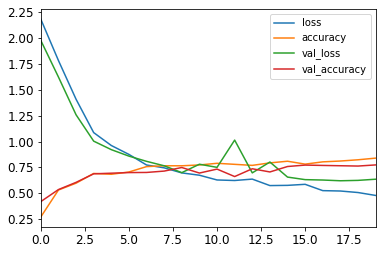

In [68]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [69]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [70]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 20ms/step - loss: 2.3133 - accuracy: 0.1680 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 0s 14ms/step - loss: 2.1850 - accuracy: 0.2760 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 2.0876 - accuracy: 0.4000 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 0s 14ms/step - loss: 1.9943 - accuracy: 0.4720 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 0s 14ms/step - loss: 1.9140 - accuracy: 0.5520 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 0s 14ms/step - loss: 1.8325 - accuracy: 0.6400 - val_loss: 1.7987 - val_accuracy: 0.6340
Epoch 7/30
16/16 [==============================] - 0s 15ms/step - loss: 1.7564 - accuracy: 0.6660 - val_loss: 1.7221 - val_accuracy: 0.6414
Epoch 8/30
16

In [71]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 0s 20ms/step - loss: 0.8376 - accuracy: 0.7440 - val_loss: 0.7980 - val_accuracy: 0.7214
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 0.7373 - accuracy: 0.7660 - val_loss: 0.7892 - val_accuracy: 0.7208
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 0.7177 - accuracy: 0.7640 - val_loss: 0.7740 - val_accuracy: 0.7084
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6715 - accuracy: 0.7720 - val_loss: 0.7195 - val_accuracy: 0.7304
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6549 - accuracy: 0.7620 - val_loss: 0.6896 - val_accuracy: 0.7428
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6421 - accuracy: 0.7760 - val_loss: 0.7115 - val_accuracy: 0.7286
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5988 - accuracy: 0.8040 - val_loss: 0.6899 - val_accuracy: 0.7368
Epoch 8/20
16

## Hashing Using a Binary Autoencoder

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4997 - rounded_accuracy: 0.7265 - val_loss: 0.4856 - val_rounded_accuracy: 0.7350
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4740 - rounded_accuracy: 0.7516 - val_loss: 0.4710 - val_rounded_accuracy: 0.7652
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4272 - rounded_accuracy: 0.7996 - val_loss: 0.4208 - val_rounded_accuracy: 0.8053
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4085 - rounded_accuracy: 0.8149 - val_loss: 0.4160 - val_rounded_accuracy: 0.8058
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4022 - rounded_accuracy: 0.8197 - val_loss: 0.4132 - val_rounded_accuracy: 0.8093
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3973 - rounded_accuracy: 0.8247 - val_loss: 0.4061 - val_rounded_accuracy: 0.8129
Epoch 7/10
1719/1719 [==================

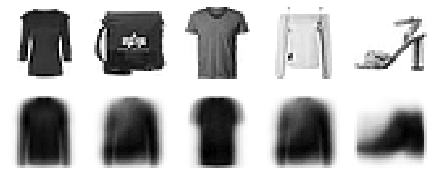

In [73]:
show_reconstructions(hashing_ae)
plt.show()

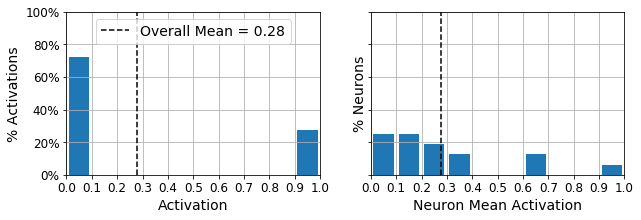

In [74]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [75]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0101000000001001
0001000000000001
0101000100001001
0001000000000001
0001010000000100
...


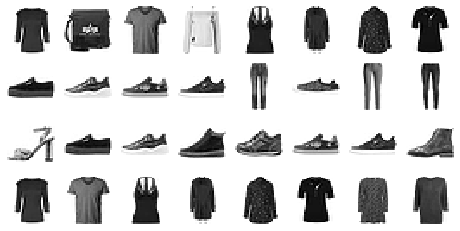

In [76]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")